In [1]:
import pandas as pd

# Leer el archivo Excel
ruta_archivo = 'pruebita2.xlsx'  # Cambia esto por la ruta a tu archivo
tabla = pd.read_excel(ruta_archivo)

# Mostrar las primeras filas de la tabla para verificar la carga de datos
print(tabla.head())


   FID     xcoord     ycoord  dengue  aegypti  albopictus    altitud
0    0 -72.373596  12.468319       0        0           0   6.894737
1    1 -71.873596  12.468319       0        0           0  32.059445
2    2 -71.373596  12.468319       0        0           0  51.054769
3    3 -72.873596  11.968319       0        0           0   1.000000
4    4 -72.373596  11.968319       0        1           0  20.146231


In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'dengue'

# Crear las variables polinomiales de latitud y longitud (hasta segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(tabla[['xcoord', 'ycoord']])

# Crear un DataFrame con los términos polinomiales
X_poly_df = pd.DataFrame(X_poly, columns=['xcoord', 'ycoord', 'xcoord^2', 'xcoord*ycoord', 'ycoord^2'])

# Agregar la constante (intercepto) al modelo
X_poly_df = sm.add_constant(X_poly_df)

# Variable dependiente (presencia/ausencia)
y = tabla['aegypti']  # Asegúrate de que la columna 'dengue' esté en el DataFrame 'tabla'

# Configurar la validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear listas para almacenar las métricas de cada iteración de la validación cruzada
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
confusion_matrices = []

# Realizar la validación cruzada
for train_index, test_index in kf.split(X_poly_df, y):
    X_train, X_test = X_poly_df.iloc[train_index], X_poly_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar el modelo de regresión logística
    modelo = sm.Logit(y_train, X_train)
    resultado = modelo.fit(disp=0)  # disp=0 evita que se impriman los resultados en cada iteración
    
    # Hacer predicciones sobre los datos de prueba
    predicciones_prob = resultado.predict(X_test)
    
    # Convertir las probabilidades en predicciones binarias (umbral de 0.5)
    predicciones_bin = (predicciones_prob >= 0.2).astype(int)
    
    # Evaluar la performance del modelo
    accuracy = accuracy_score(y_test, predicciones_bin)
    precision = precision_score(y_test, predicciones_bin)
    recall = recall_score(y_test, predicciones_bin)
    f1 = f1_score(y_test, predicciones_bin)
    
    # Guardar las métricas
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Guardar la matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicciones_bin)
    confusion_matrices.append(conf_matrix)

# Mostrar los resultados promedio de las métricas
print(f"Promedio Exactitud (Accuracy): {np.mean(accuracy_list):.2f}")
print(f"Promedio Precisión (Precision): {np.mean(precision_list):.2f}")
print(f"Promedio Sensibilidad (Recall): {np.mean(recall_list):.2f}")
print(f"Promedio F1-Score: {np.mean(f1_list):.2f}")

# Mostrar las matrices de confusión
print("Matrices de confusión de cada iteración:")
for i, cm in enumerate(confusion_matrices):
    print(f"Iteración {i+1}:")
    print(cm)


Promedio Exactitud (Accuracy): 0.80
Promedio Precisión (Precision): 0.59
Promedio Sensibilidad (Recall): 0.81
Promedio F1-Score: 0.69
Matrices de confusión de cada iteración:
Iteración 1:
[[760 196]
 [ 72 266]]
Iteración 2:
[[757 199]
 [ 54 283]]
Iteración 3:
[[757 199]
 [ 62 275]]
Iteración 4:
[[785 170]
 [ 64 274]]
Iteración 5:
[[770 185]
 [ 61 277]]


In [14]:
predicciones_prue = resultado.predict(X_poly_df)
display(predicciones_prue)

0       0.120116
1       0.116289
2       0.112719
3       0.123901
4       0.119987
          ...   
6461    0.000366
6462    0.000450
6463    0.000554
6464    0.000682
6465    0.000270
Length: 6466, dtype: float64

In [15]:
print(resultado.summary())

                           Logit Regression Results                           
Dep. Variable:                aegypti   No. Observations:                 5173
Model:                          Logit   Df Residuals:                     5167
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Sep 2024   Pseudo R-squ.:                  0.4021
Time:                        14:59:59   Log-Likelihood:                -1775.5
converged:                       True   LL-Null:                       -2969.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.1114      1.683      8.382      0.000      10.812      17.411
xcoord            0.4445      0.056      7.915      0.000       0.334       0.555
ycoord           -0.4394      0.037    -

In [17]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'FID'

# Coeficientes del modelo sin altitud
coef_const = 14.1114
coef_xcoord = 0.4445
coef_ycoord = -0.0030
coef_xcoord2 =  0.0026
coef_xcoord_ycoord = 0.0067
coef_ycoord2 = -0.0018

# Calcular el logit y la probabilidad
def calcular_probabilidades_sin_altitud(row):
    x = row['xcoord']
    y = row['ycoord']
    
    # Calcular el logit
    logit = (coef_const +
             coef_xcoord * x +
             coef_ycoord * y +
             coef_xcoord2 * x**2 +
             coef_xcoord_ycoord * x * y +
             coef_ycoord2 * y**2)
    
    # Convertir el logit a probabilidad usando la función sigmoide
    probabilidad = 1 / (1 + np.exp(-logit))
    
    return pd.Series([logit, probabilidad])

# Aplicar el cálculo del logit y la probabilidad
tabla[['logit', 'probabilidad_dengue']] = tabla.apply(calcular_probabilidades_sin_altitud, axis=1)

# Calcular n1 (presencias) y n0 (ausencias) de dengue
n1 = tabla['aegypti'].sum()  # Número total de presencias
n0 = len(tabla) - n1  # Número total de ausencias

# Calcular la favorabilidad F
def calcular_favorabilidad(probabilidad):
    if probabilidad == 0:
        return 0
    if probabilidad == 1:
        return np.inf
    # Calcular F usando la fórmula proporcionada
    P_over_1_minus_P = probabilidad / (1 - probabilidad)
    n1_over_n0 = n1 / n0
    F = P_over_1_minus_P / (n1_over_n0 + P_over_1_minus_P)
    return F

# Aplicar el cálculo de favorabilidad
tabla['favorabilidad_F'] = tabla['probabilidad_dengue'].apply(calcular_favorabilidad)

# Mostrar el DataFrame con las nuevas columnas
resultado = tabla[['FID', 'xcoord', 'ycoord', 'logit', 'probabilidad_dengue', 'favorabilidad_F']]

# Mostrar el resultado
print(resultado.head())


   FID     xcoord     ycoord      logit  probabilidad_dengue  favorabilidad_F
0    0 -72.373596  12.468319 -10.803184             0.000020         0.000058
1    1 -71.873596  12.468319 -10.726686             0.000022         0.000062
2    2 -71.373596  12.468319 -10.648889             0.000024         0.000067
3    3 -72.873596  11.968319 -10.610762             0.000025         0.000070
4    4 -72.373596  11.968319 -10.537239             0.000027         0.000075


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord', 'altitud' y 'dengue'

# Crear las variables polinomiales de latitud, longitud y altitud (hasta segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(tabla[['xcoord', 'ycoord']])

# Crear un DataFrame con los términos polinomiales
X_poly_df = pd.DataFrame(X_poly, columns=['xcoord', 'ycoord', 'xcoord^2', 'xcoord*ycoord', 'ycoord^2'])

# Agregar la constante (intercepto) al modelo
X_poly_df = sm.add_constant(X_poly_df)

# Variable dependiente (presencia/ausencia)
y = tabla['dengue']  # Asegúrate de que la columna 'dengue' esté en el DataFrame 'tabla'

# Separar los datos en conjuntos de entrenamiento (80%) y prueba (20%)
#X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)
X_train=X_poly_df
y_train=y

# Ajustar el modelo de regresión logística con los datos de entrenamiento
modelo = sm.Logit(y_train, X_train)
resultado = modelo.fit(maxiter=100)

# Mostrar el resumen del modelo
print(resultado.summary())

# Hacer predicciones sobre los datos de prueba
predicciones_probab = resultado.predict(X_train)

print(predicciones_probab)

Optimization terminated successfully.
         Current function value: 0.301868
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 dengue   No. Observations:                 6466
Model:                          Logit   Df Residuals:                     6460
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Sep 2024   Pseudo R-squ.:                  0.1445
Time:                        14:46:33   Log-Likelihood:                -1951.9
converged:                       True   LL-Null:                       -2281.5
Covariance Type:            nonrobust   LLR p-value:                3.074e-140
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.7939      1.172      4.945      0.000       3.497       8.091
xcoord            0.

In [5]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'FID'

# Coeficientes del modelo sin altitud
coef_const = 5.7939
coef_xcoord = 0.3011
coef_ycoord = -0.3856
coef_xcoord2 = 0.0027
coef_xcoord_ycoord = -0.0059
coef_ycoord2 = -0.0012

# Calcular el logit y la probabilidad
def calcular_probabilidades_sin_altitud(row):
    x = row['xcoord']
    y = row['ycoord']
    
    # Calcular el logit
    logit = (coef_const +
             coef_xcoord * x +
             coef_ycoord * y +
             coef_xcoord2 * x**2 +
             coef_xcoord_ycoord * x * y +
             coef_ycoord2 * y**2)
    
    # Convertir el logit a probabilidad usando la función sigmoide
    probabilidad = 1 / (1 + np.exp(-logit))
    
    return pd.Series([logit, probabilidad])

# Aplicar el cálculo del logit y la probabilidad
tabla[['logit', 'probabilidad_dengue']] = tabla.apply(calcular_probabilidades_sin_altitud, axis=1)

# Calcular n1 (presencias) y n0 (ausencias) de dengue
n1 = tabla['dengue'].sum()  # Número total de presencias
n0 = len(tabla) - n1  # Número total de ausencias

# Calcular la favorabilidad F
def calcular_favorabilidad(probabilidad):
    if probabilidad == 0:
        return 0
    if probabilidad == 1:
        return np.inf
    # Calcular F usando la fórmula proporcionada
    P_over_1_minus_P = probabilidad / (1 - probabilidad)
    n1_over_n0 = n1 / n0
    F = P_over_1_minus_P / (n1_over_n0 + P_over_1_minus_P)
    return F

# Aplicar el cálculo de favorabilidad
tabla['favorabilidad_F'] = tabla['probabilidad_dengue'].apply(calcular_favorabilidad)

# Mostrar el DataFrame con las nuevas columnas
resultado = tabla[['FID', 'xcoord', 'ycoord', 'logit', 'probabilidad_dengue', 'favorabilidad_F']]

# Mostrar el resultado
print(resultado.head())


   FID     xcoord     ycoord     logit  probabilidad_dengue  favorabilidad_F
0    0 -72.373596  12.468319 -1.525669             0.178628         0.630476
1    1 -71.873596  12.468319 -1.606634             0.167056         0.611423
2    2 -71.373596  12.468319 -1.686249             0.156270         0.592348
3    3 -72.873596  11.968319 -1.450868             0.189868         0.647727
4    4 -72.373596  11.968319 -1.531709             0.177744         0.629068


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'dengue'

# Crear las variables polinomiales de latitud y longitud (hasta segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(tabla[['xcoord', 'ycoord']])

# Crear un DataFrame con los términos polinomiales
X_poly_df = pd.DataFrame(X_poly, columns=['xcoord', 'ycoord', 'xcoord^2', 'xcoord*ycoord', 'ycoord^2'])

# Agregar la constante (intercepto) al modelo
X_poly_df = sm.add_constant(X_poly_df)

# Variable dependiente (presencia/ausencia)
y = tabla['dengue']  # Asegúrate de que la columna 'dengue' esté en el DataFrame 'tabla'

# Separar los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión logística con los datos de entrenamiento
modelo = sm.Logit(y_train, X_train)
resultado = modelo.fit(maxiter=100)

# Mostrar el resumen del modelo
print(resultado.summary())

# Hacer predicciones sobre los datos de prueba
predicciones_prob = resultado.predict(X_test)

# Convertir las probabilidades en predicciones binarias (usando 0.5 como umbral)
predicciones_bin = (predicciones_prob >= 0.5).astype(int)

# Evaluar la performance del modelo

# 1. Accuracy (Exactitud)
accuracy = accuracy_score(y_test, predicciones_bin)
print(f"Exactitud (Accuracy): {accuracy:.2f}")

# 2. Precision
precision = precision_score(y_test, predicciones_bin)
print(f"Precisión (Precision): {precision:.2f}")

# 3. Recall (Sensibilidad)
recall = recall_score(y_test, predicciones_bin)
print(f"Sensibilidad (Recall): {recall:.2f}")

# 4. F1-Score
f1 = f1_score(y_test, predicciones_bin)
print(f"F1-Score: {f1:.2f}")

# 5. Matriz de confusión
conf_matrix = confusion_matrix(y_test, predicciones_bin)
print("Matriz de confusión:")
print(conf_matrix)


Optimization terminated successfully.
         Current function value: 0.295078
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 dengue   No. Observations:                 5172
Model:                          Logit   Df Residuals:                     5166
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                  0.1455
Time:                        21:49:34   Log-Likelihood:                -1526.1
converged:                       True   LL-Null:                       -1786.1
Covariance Type:            nonrobust   LLR p-value:                4.166e-110
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.6366      1.319      4.272      0.000       3.051       8.222
xcoord            0.

In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'dengue'

# Crear las variables polinomiales de latitud y longitud (hasta segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(tabla[['xcoord', 'ycoord']])

# Crear un DataFrame con los términos polinomiales
X_poly_df = pd.DataFrame(X_poly, columns=['xcoord', 'ycoord', 'xcoord^2', 'xcoord*ycoord', 'ycoord^2'])

# Agregar la constante (intercepto) al modelo
X_poly_df = sm.add_constant(X_poly_df)

# Variable dependiente (presencia/ausencia)
y = tabla['dengue']  # Asegúrate de que la columna 'dengue' esté en el DataFrame 'tabla'

# Separar los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión logística con los datos de entrenamiento
modelo = sm.Logit(y_train, X_train)
resultado = modelo.fit(maxiter=100)

# Mostrar el resumen del modelo
print(resultado.summary())

# Hacer predicciones sobre los datos de prueba
predicciones_prob = resultado.predict(X_test)

# Convertir las probabilidades en predicciones binarias (usando 0.2 como umbral)
umbral = 0.2
predicciones_bin = (predicciones_prob >= umbral).astype(int)

# Evaluar la performance del modelo

# 1. Accuracy (Exactitud)
accuracy = accuracy_score(y_test, predicciones_bin)
print(f"Exactitud (Accuracy): {accuracy:.2f}")

# 2. Precision
precision = precision_score(y_test, predicciones_bin)
print(f"Precisión (Precision): {precision:.2f}")

# 3. Recall (Sensibilidad)
recall = recall_score(y_test, predicciones_bin)
print(f"Sensibilidad (Recall): {recall:.2f}")

# 4. F1-Score
f1 = f1_score(y_test, predicciones_bin)
print(f"F1-Score: {f1:.2f}")

# 5. Matriz de confusión
conf_matrix = confusion_matrix(y_test, predicciones_bin)
print("Matriz de confusión:")
print(conf_matrix)


Optimization terminated successfully.
         Current function value: 0.296915
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 dengue   No. Observations:                 4526
Model:                          Logit   Df Residuals:                     4520
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                  0.1467
Time:                        22:21:42   Log-Likelihood:                -1343.8
converged:                       True   LL-Null:                       -1574.9
Covariance Type:            nonrobust   LLR p-value:                 1.208e-97
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.6889      1.388      4.098      0.000       2.968       8.410
xcoord            0.

In [22]:
import numpy as np

# Coeficientes del modelo
beta_0 = 5.6889
beta_1 = 0.2905
beta_2 = -0.3681
beta_3 = 0.0025
beta_4 = -0.0056
beta_5 = -0.0014

# Calcular el logit (z) para cada fila del DataFrame
tabla['logit'] = (beta_0 +
                  beta_1 * tabla['xcoord'] +
                  beta_2 * tabla['ycoord'] +
                  beta_3 * tabla['xcoord'] ** 2 +
                  beta_4 * (tabla['xcoord'] * tabla['ycoord']) +
                  beta_5 * tabla['ycoord'] ** 2)

# Calcular la probabilidad de dengue usando la función logística
tabla['probabilidad_dengue'] = 1 / (1 + np.exp(-tabla['logit']))

# Seleccionar las columnas FID, xcoord, ycoord y la nueva columna de probabilidad
resultado = tabla[['FID', 'xcoord', 'ycoord', 'logit','probabilidad_dengue']]

# Mostrar las primeras filas del resultado
print(resultado.head())


   FID     xcoord     ycoord     logit  probabilidad_dengue
0    0 -72.373596  12.468319 -1.994705             0.119760
1    1 -71.873596  12.468319 -2.064676             0.112578
2    2 -71.373596  12.468319 -2.133396             0.105893
3    3 -72.873596  11.968319 -1.926375             0.127152
4    4 -72.373596  11.968319 -1.996196             0.119603


In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord', 'altitud' y 'dengue'

# Crear las variables polinomiales de latitud, longitud y altitud (hasta segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(tabla[['xcoord', 'ycoord', 'altitud']])

# Crear un DataFrame con los términos polinomiales
X_poly_df = pd.DataFrame(X_poly, columns=['xcoord', 'ycoord', 'altitud', 'xcoord^2', 'xcoord*ycoord', 'ycoord^2', 'xcoord*altitud', 'ycoord*altitud', 'altitud^2'])

# Agregar la constante (intercepto) al modelo
X_poly_df = sm.add_constant(X_poly_df)

# Variable dependiente (presencia/ausencia)
y = tabla['dengue']  # Asegúrate de que la columna 'dengue' esté en el DataFrame 'tabla'

# Separar los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión logística con los datos de entrenamiento
modelo = sm.Logit(y_train, X_train)
resultado = modelo.fit(maxiter=100)

# Mostrar el resumen del modelo
print(resultado.summary())

# Hacer predicciones sobre los datos de prueba
predicciones_prob = resultado.predict(X_test)

# Convertir las probabilidades en predicciones binarias (usando un umbral de 0.15)
umbral = 0.5
predicciones_bin = (predicciones_prob >= umbral).astype(int)

# Evaluar la performance del modelo

# 1. Exactitud (Accuracy)
accuracy = accuracy_score(y_test, predicciones_bin)
print(f"Exactitud (Accuracy): {accuracy:.2f}")

# 2. Precisión (Precision)
precision = precision_score(y_test, predicciones_bin)
print(f"Precisión (Precision): {precision:.2f}")

# 3. Sensibilidad (Recall)
recall = recall_score(y_test, predicciones_bin)
print(f"Sensibilidad (Recall): {recall:.2f}")

# 4. F1-Score
f1 = f1_score(y_test, predicciones_bin)
print(f"F1-Score: {f1:.2f}")

# 5. Matriz de confusión
conf_matrix = confusion_matrix(y_test, predicciones_bin)
print("Matriz de confusión:")
print(conf_matrix)


Optimization terminated successfully.
         Current function value: 0.293234
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 dengue   No. Observations:                 5172
Model:                          Logit   Df Residuals:                     5162
Method:                           MLE   Df Model:                            9
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                  0.1509
Time:                        22:15:23   Log-Likelihood:                -1516.6
converged:                       True   LL-Null:                       -1786.1
Covariance Type:            nonrobust   LLR p-value:                2.642e-110
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.1915      1.356      3.828      0.000       2.533       7.850
xcoord           

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Supongamos que tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord', 'altitud', y 'FID'

# Coeficientes del modelo ajustado
coef_const = 5.1915
coef_xcoord = 0.2651
coef_ycoord = -0.4202
coef_altitud = -0.0028
coef_xcoord2 = 0.0022
coef_xcoord_ycoord = -0.0063
coef_ycoord2 = -4.991e-05
coef_xcoord_altitud = -0.0016
coef_ycoord_altitud = -1.637e-05
coef_altitud2 = -2.633e-07

# Aplicar el modelo para calcular la probabilidad de dengue
def calcular_probabilidad(row):
    x = row['xcoord']
    y = row['ycoord']
    z = row['altitud']
    
    # Calcular el logit
    logit = (coef_const +
             coef_xcoord * x +
             coef_ycoord * y +
             coef_altitud * z +
             coef_xcoord2 * x**2 +
             coef_xcoord_ycoord * x * y +
             coef_ycoord2 * y**2 +
             coef_xcoord_altitud * x * z +
             coef_ycoord_altitud * y * z +
             coef_altitud2 * z**2)
    
    # Convertir el logit a probabilidad usando la función sigmoide
    probabilidad = 1 / (1 + np.exp(-logit))
    return probabilidad

# Crear una nueva columna 'probabilidad_dengue' en el DataFrame con las probabilidades calculadas
tabla['probabilidad_dengue'] = tabla.apply(calcular_probabilidad, axis=1)

# Mostrar el DataFrame con la columna FID y la probabilidad de dengue
resultado = tabla[['FID', 'xcoord', 'ycoord', 'altitud', 'probabilidad_dengue']]

# Mostrar el resultado
print(resultado.head())


   FID     xcoord     ycoord    altitud  probabilidad_dengue
0    0 -72.373596  12.468319   6.894737             0.221736
1    1 -71.873596  12.468319  32.059445             0.816309
2    2 -71.373596  12.468319  51.054769             0.971065
3    3 -72.873596  11.968319   1.000000             0.133311
4    4 -72.373596  11.968319  20.146231             0.555251


In [33]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord', 'altitud', y 'FID'

# Coeficientes del modelo ajustado
coef_const = 5.1915
coef_xcoord = 0.2651
coef_ycoord = -0.4202
coef_altitud = -0.0028
coef_xcoord2 = 0.0022
coef_xcoord_ycoord = -0.0063
coef_ycoord2 = -4.991e-05
coef_xcoord_altitud = -0.0016
coef_ycoord_altitud = -1.637e-05
coef_altitud2 = -2.633e-07

# Calcular el logit y la probabilidad
def calcular_probabilidades(row):
    x = row['xcoord']
    y = row['ycoord']
    z = row['altitud']
    
    # Calcular el logit
    logit = (coef_const +
             coef_xcoord * x +
             coef_ycoord * y +
             coef_altitud * z +
             coef_xcoord2 * x**2 +
             coef_xcoord_ycoord * x * y +
             coef_ycoord2 * y**2 +
             coef_xcoord_altitud * x * z +
             coef_ycoord_altitud * y * z +
             coef_altitud2 * z**2)
    
    # Convertir el logit a probabilidad usando la función sigmoide
    probabilidad = 1 / (1 + np.exp(-logit))
    
    return pd.Series([logit, probabilidad])

# Aplicar el cálculo del logit y la probabilidad
tabla[['logit', 'probabilidad_dengue']] = tabla.apply(calcular_probabilidades, axis=1)

# Calcular n1 (presencias) y n0 (ausencias) de dengue
n1 = tabla['dengue'].sum()  # Número total de presencias
n0 = len(tabla) - n1  # Número total de ausencias

# Calcular la favorabilidad F
def calcular_favorabilidad(probabilidad):
    if probabilidad == 0:
        return 0
    if probabilidad == 1:
        return np.inf
    # Calcular F usando la fórmula proporcionada
    P_over_1_minus_P = probabilidad / (1 - probabilidad)
    n1_over_n0 = n1 / n0
    F = P_over_1_minus_P / (n1_over_n0 + P_over_1_minus_P)
    return F

# Aplicar el cálculo de favorabilidad
tabla['favorabilidad_F'] = tabla['probabilidad_dengue'].apply(calcular_favorabilidad)

# Mostrar el DataFrame con las nuevas columnas
resultado = tabla[['FID', 'xcoord', 'ycoord', 'altitud', 'logit', 'probabilidad_dengue', 'favorabilidad_F']]

# Mostrar el resultado
print(resultado.head())



   FID     xcoord     ycoord    altitud     logit  probabilidad_dengue  \
0    0 -72.373596  12.468319   6.894737 -1.255579             0.221736   
1    1 -71.873596  12.468319  32.059445  1.491537             0.816309   
2    2 -71.373596  12.468319  51.054769  3.513336             0.971065   
3    3 -72.873596  11.968319   1.000000 -1.871992             0.133311   
4    4 -72.373596  11.968319  20.146231  0.221909             0.555251   

   favorabilidad_F  
0         0.690904  
1         0.972117  
2         0.996216  
3         0.546847  
4         0.907362  


In [35]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes un DataFrame 'tabla' con las columnas 'xcoord', 'ycoord' y 'FID'

# Coeficientes del modelo sin altitud
coef_const = 5.6889
coef_xcoord = 0.2905
coef_ycoord = -0.3681
coef_xcoord2 = 0.0025
coef_xcoord_ycoord = -0.0056
coef_ycoord2 = -0.0014

# Calcular el logit y la probabilidad
def calcular_probabilidades_sin_altitud(row):
    x = row['xcoord']
    y = row['ycoord']
    
    # Calcular el logit
    logit = (coef_const +
             coef_xcoord * x +
             coef_ycoord * y +
             coef_xcoord2 * x**2 +
             coef_xcoord_ycoord * x * y +
             coef_ycoord2 * y**2)
    
    # Convertir el logit a probabilidad usando la función sigmoide
    probabilidad = 1 / (1 + np.exp(-logit))
    
    return pd.Series([logit, probabilidad])

# Aplicar el cálculo del logit y la probabilidad
tabla[['logit', 'probabilidad_dengue']] = tabla.apply(calcular_probabilidades_sin_altitud, axis=1)

# Calcular n1 (presencias) y n0 (ausencias) de dengue
n1 = tabla['dengue'].sum()  # Número total de presencias
n0 = len(tabla) - n1  # Número total de ausencias

# Calcular la favorabilidad F
def calcular_favorabilidad(probabilidad):
    if probabilidad == 0:
        return 0
    if probabilidad == 1:
        return np.inf
    # Calcular F usando la fórmula proporcionada
    P_over_1_minus_P = probabilidad / (1 - probabilidad)
    n1_over_n0 = n1 / n0
    F = P_over_1_minus_P / (n1_over_n0 + P_over_1_minus_P)
    return F

# Aplicar el cálculo de favorabilidad
tabla['favorabilidad_F'] = tabla['probabilidad_dengue'].apply(calcular_favorabilidad)

# Mostrar el DataFrame con las nuevas columnas
resultado = tabla[['FID', 'xcoord', 'ycoord', 'logit', 'probabilidad_dengue', 'favorabilidad_F']]

# Mostrar el resultado
print(resultado.head())


   FID     xcoord     ycoord     logit  probabilidad_dengue  favorabilidad_F
0    0 -72.373596  12.468319 -1.994705             0.119760         0.516300
1    1 -71.873596  12.468319 -2.064676             0.112578         0.498814
2    2 -71.373596  12.468319 -2.133396             0.105893         0.481642
3    3 -72.873596  11.968319 -1.926375             0.127152         0.533339
4    4 -72.373596  11.968319 -1.996196             0.119603         0.515928


In [36]:
display(resultado)


,FID,xcoord,ycoord,logit,probabilidad_dengue,favorabilidad_F
0,0,-72.373596,12.468319,-1.994705,0.119760,0.516300
1,1,-71.873596,12.468319,-2.064676,0.112578,0.498814
2,2,-71.373596,12.468319,-2.133396,0.105893,0.481642
3,3,-72.873596,11.968319,-1.926375,0.127152,0.533339
4,4,-72.373596,11.968319,-1.996196,0.119603,0.515928
...,...,...,...,...,...,...
6461,6461,-66.873596,-55.031681,-7.149335,0.000785,0.006124
6462,6462,-66.373596,-55.031681,-7.016556,0.000896,0.006987
6463,6463,-65.873596,-55.031681,-6.882526,0.001024,0.007982
6464,6464,-65.373596,-55.031681,-6.747246,0.001173,0.009127


In [37]:
pd.set_option('display.max_rows', 100)  # Ajustar el número máximo de filas a mostrar
display(resultado.head(100))

,FID,xcoord,ycoord,logit,probabilidad_dengue,favorabilidad_F
0,0,-72.373596,12.468319,-1.994705,0.119760,0.516300
1,1,-71.873596,12.468319,-2.064676,0.112578,0.498814
2,2,-71.373596,12.468319,-2.133396,0.105893,0.481642
3,3,-72.873596,11.968319,-1.926375,0.127152,0.533339
4,4,-72.373596,11.968319,-1.996196,0.119603,0.515928
5,5,-71.873596,11.968319,-2.064766,0.112569,0.498791
6,6,-71.373596,11.968319,-2.132086,0.106017,0.481969
7,7,-70.873596,11.968319,-2.198157,0.099916,0.465498
8,8,-70.373596,11.968319,-2.262977,0.094236,0.449412
9,9,-69.873596,11.968319,-2.326547,0.088948,0.433738


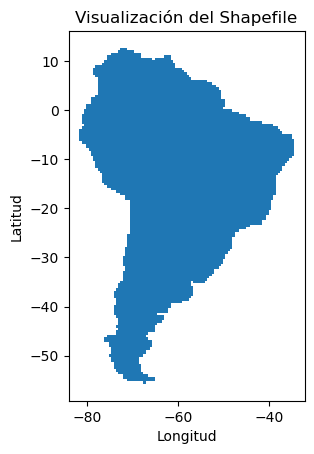

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Visualizar el archivo SHP
gdf.plot()
plt.title('Visualización del Shapefile')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


In [20]:
pip install geopandas matplotlib openstreetmap


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for openstreetmap: filename=openstreetmap-0.0.19-py3-none-any.whl size=9629 sha256=64a3f08997c92e5d48b4e7e0816aae6cc4fc63fb8afaf930001f326052ca5c2b
  Stored in directory: c:\users\usuario\appdata\local\pip\cache\wheels\55\d3\c6\e5ab919c96102592ebe69e1dcfe9c9897b69448eaba6e76cbd
Successfully built openstreetmap
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install contextily

  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/fb/46/07a029b73f9a5c7bbf9b538e6441c42014a448f335a1cc780616f2594bad/contextily-1.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for mercantile from https://files.pythonhosted.org/packages/b2/d6/de0cc74f8d36976aeca0dd2e9cbf711882ff8e177495115fd82459afdc4d/mercantile-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/a0/28/ed59f8b361122c91273f2545c50636441927b257e02fbd32f7953987017a/rasterio-1.3.11-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for cligj>=0.5 from https://files.pythonhosted.org/packages/73/86/43fa9f15c5b9fb6e82620428827cd3c284aa933431405d1bcf5231ae3d3e/cligj-0.7.2-py3-none

In [26]:
pip install xlrd

  Obtaining dependency information for xlrd from https://files.pythonhosted.org/packages/a6/0c/c2a72d51fe56e08a08acc85d13013558a2d793028ae7385448a6ccdfae64/xlrd-2.0.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/96.5 kB ? eta -:--:--
   ---------------------------------------- 96.5/96.5 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


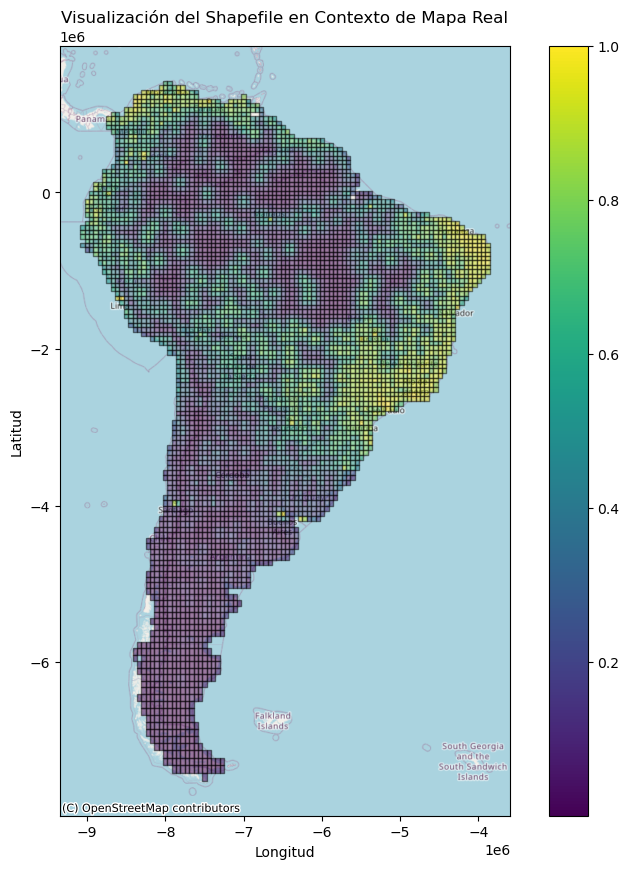

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
# Aquí asumimos que el ID es el mismo en ambas fuentes y se llama 'FID'
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Configurar el sistema de coordenadas del mapa base
gdf = gdf.to_crs(epsg=3857)

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 10))

# Visualizar el shapefile en el contexto del mapa
gdf.plot(column='dengueF', ax=ax, legend=True,
         cmap='viridis', edgecolor='black', alpha=0.5)

# Añadir el mapa base
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Configurar etiquetas y título
plt.title('Visualización del Shapefile en Contexto de Mapa Real')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


In [34]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengue_SA_F' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengue_SA_F' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Crear un mapa base centrado en el centro del shapefile
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengue_SA_F
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    color = '#{:02x}{:02x}{:02x}'.format(
        int(value * 255),
        0,
        255 - int(value * 255)
    )
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo.html')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_30132\3889601231.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)


In [35]:
Lo mismo pero quiero que se delimiten en blanco las fronteras de los paises

SyntaxError: invalid syntax (3756042923.py, line 1)

In [36]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Crear un mapa base centrado en el centro del shapefile
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        color = 'blue'
    elif value <= 0.8:
        color = 'orange'
    else:
        color = 'red'
    return {
        'fillColor': color,
        'color': 'white',  # Límites de países en blanco
        'weight': 2,
        'fillOpacity': 0.6
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo.html')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_30132\3790134798.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)


In [38]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Crear un mapa base centrado en el centro del shapefile con un mayor nivel de transparencia
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=10,
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
    overlay=True,
    control_scale=True
)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        color = 'green'
    elif value <= 0.8:
        color = 'orange'
    else:
        color = 'red'
    return {
        'fillColor': color,
        'color': 'white',  # Límites de países en blanco
        'weight': 2,
        'fillOpacity': 0.2  # Mayor transparencia en el relleno
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo.html')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_30132\4017030950.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],


In [39]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Crear un mapa base centrado en el centro del shapefile con un mayor nivel de transparencia
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=10,
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        fill_color = 'green'
    elif value <= 0.8:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    
    return {
        'fillColor': fill_color,
        'color': 'black',  # Color del borde
        'weight': 0.5,     # Grosor del borde
        'fillOpacity': 0.2, # Mayor transparencia en el relleno
        'opacity': 0.3     # Transparencia del borde
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo.html')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_30132\2957880371.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],


In [40]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Coordenadas aproximadas para centrar el mapa en América Latina
lat_mean = -15
lon_mean = -60

# Crear un mapa base centrado en América Latina
m = folium.Map(
    location=[lat_mean, lon_mean],
    zoom_start=4,  # Ajusta el nivel de zoom para mostrar América Latina
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        fill_color = 'green'
    elif value <= 0.8:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    
    return {
        'fillColor': fill_color,
        'color': 'black',  # Color del borde
        'weight': 0.5,     # Grosor del borde
        'fillOpacity': 0.4, # Mayor transparencia en el relleno
        'opacity': 0.3     # Transparencia del borde
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo_latam.html')


In [41]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Coordenadas aproximadas para centrar el mapa en Uruguay
lat_uruguay = -32.5
lon_uruguay = -56.0

# Crear un mapa base centrado en Uruguay
m = folium.Map(
    location=[lat_uruguay, lon_uruguay],
    zoom_start=6,  # Ajusta el nivel de zoom para enfocarse en Uruguay
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# Ajustar el límite de vista del mapa para incluir América Latina al alejarse
folium.LatLngPopup().add_to(m)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        fill_color = 'green'
    elif value <= 0.8:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    
    return {
        'fillColor': fill_color,
        'color': 'black',  # Color del borde
        'weight': 0.5,     # Grosor del borde
        'fillOpacity': 0.4, # Mayor transparencia en el relleno
        'opacity': 0.3     # Transparencia del borde
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Configurar límites de vista para incluir América Latina
bounds = [[-60, -75], [15, -35]]  # Ajusta estos límites según sea necesario
m.fit_bounds(bounds)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo_uruguay_latam.html')


In [44]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Coordenadas aproximadas para centrar el mapa en Uruguay
lat_uruguay = -32.5
lon_uruguay = -56.0

# Crear un mapa base centrado en Uruguay
m = folium.Map(
    location=[lat_uruguay, lon_uruguay],
    zoom_start=8,  # Ajusta el nivel de zoom para enfocarse en Uruguay
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        fill_color = 'green'
    elif value <= 0.8:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    
    return {
        'fillColor': fill_color,
        'color': 'black',  # Color del borde
        'weight': 0.5,     # Grosor del borde
        'fillOpacity': 0.4, # Mayor transparencia en el relleno
        'opacity': 0.3     # Transparencia del borde
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Configurar límites de vista para incluir América Latina al alejarse
# Los límites de vista deben ser configurados para abarcar toda América Latina
bounds = [[-60, -75], [15, -35]]  # Ajusta estos límites para América Latina
m.fit_bounds(bounds)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo_uruguay_latam.html')


In [57]:
import geopandas as gpd
import pandas as pd
import folium

# Cargar el archivo SHP
gdf = gpd.read_file('Hexagonos_Parasites_and_Vectors.shp')

# Cargar el archivo Excel con los valores de dengue
tabla_dengue = pd.read_excel('tabla_completa_dengue_sa.xls')

# Asegúrate de que el ID en el SHP y en el Excel se alinean para fusionar
gdf = gdf.merge(tabla_dengue[['FID', 'dengueF']], on='FID', how='left')

# Reemplazar valores NaN en 'dengueF' con 0 o un valor predeterminado
gdf['dengueF'].fillna(0, inplace=True)

# Convertir la columna 'dengueF' a un rango entre 0 y 1 para usar en la escala de colores
gdf['dengueF'] = gdf['dengueF'].clip(0, 1)

# Configurar el sistema de coordenadas
gdf = gdf.to_crs(epsg=4326)  # Usar EPSG 4326 para lat/lon

# Coordenadas aproximadas para centrar el mapa en Uruguay
lat_uruguay = -32.5
lon_uruguay = -56.0

# Crear un mapa base centrado en Uruguay
m = folium.Map(
    location=[lat_uruguay, lon_uruguay],
    zoom_start=6,  # Ajusta el nivel de zoom para enfocarse en Uruguay
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='Map data © <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# Convertir el GeoDataFrame a un formato que Folium pueda usar
geojson_data = gdf.to_json()

# Función para asignar colores en función del valor de dengueF
def style_function(feature):
    value = feature['properties'].get('dengueF', 0)
    if value <= 0.2:
        fill_color = 'green'
    elif value <= 0.8:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    
    return {
        'fillColor': fill_color,
        'color': 'black',  # Color del borde
        'weight': 0.5,     # Grosor del borde
        'fillOpacity': 0.4, # Mayor transparencia en el relleno
        'opacity': 0.3     # Transparencia del borde
    }

# Añadir el GeoJSON al mapa
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Añadir una capa de control para el GeoJSON
folium.LayerControl().add_to(m)

# Configurar límites de vista para incluir América Latina al alejarse
bounds = [[-35.5, -58.0], [-30.0, -53.0]]  # Ajusta estos límites para América Latina
m.fit_bounds(bounds)

# Guardar el mapa en un archivo HTML
m.save('mapa_interactivo_uruguay_latam.html')


